# 3a_Training_7b_LoRA_balanced
## Notebook Overview: 

This notebook does the fine-tuning. It trains the baseline model using LoRA (Low-Rank Adaptation) on a balanced and preprocessed dataset. It also evaluates the fine-tuned model for all question types using the evaluation suite. 

In [ ]:
! pip install datasets
! pip install rouge_score

! python -m spacy download en_core_web_md
! pip install bert_score


import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import pprint

from datasets import Dataset, DatasetDict

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)

import re
from tqdm import tqdm
import torch

from peft import LoraConfig, get_peft_model, TaskType

import json
import pprint
import pprint
# Import weights and biases
import wandb
# Import kaggle secrets
from google.colab import userdata


In [39]:
from evaluation_suite import EvaluationSuite

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open('/content/drive/MyDrive/NLP/00_Data/train_dataset_balanced_shuffled.json', 'r') as f:
    trainset = json.load(f)

# Load test_dataset
with open('/content/drive/MyDrive/NLP/00_Data/test_dataset_balanced_shuffled.json', 'r') as f:
    testset = json.load(f)

In [34]:
print("Trainsets:")
for split, split_data in trainset.items():
  print(f"{split}: {len(split_data)}")

print("\nTestsets:")
for split, split_data in testset.items():
  print(f"{split}: {len(split_data)}")

Trainsets:
true_false: 24281
multiple_choice: 70000
short_answer: 54060
multi_hop: 15763

Testsets:
true_false: 5971
multiple_choice: 20000
short_answer: 54060
multi_hop: 15763


In [7]:
trainset = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in trainset.items()
})

testset = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in testset.items()
})

# Add model_input to each dataset

In [43]:
def build_prompt(prompt_style: str, question: str):
  return prompt_style.replace("{_question_var_}", question)


def generate_model_input(example):

    if example['type'] == 'multiple_choice':
      prompt_style_multiple_choice = """
      "{_question_var_}"

      ### What is the correct answer? Please state only the letter:
      """
      question = example['question']
      options = example['options']

      model_input = question + '\nOptions:\n'
      for key, val in options.items():
          model_input += f"{key}. {val}\n"

      example['prompt'] = build_prompt(prompt_style_multiple_choice, model_input)
      example["answer"] = example.pop("correct_answer")
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'true_false':
      prompt_style_true_false = """
      "{_question_var_}"

      ### Is this statement true or false? Please state only False or True:
      """
      example['prompt'] = build_prompt(prompt_style_true_false, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'short_answer':
      prompt_style_short_answer = """
      "{_question_var_}"

      ### You are a medical expert and equipped to answer this specific question. Please answer:
      """
      example['prompt'] = build_prompt(prompt_style_short_answer, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'multi_hop':
      prompt_style_multi_hop = """
      "{_question_var_}"

      ### You are a medical expert and equipped to answer this specific question. Please answer the question and elaborate what steps you took:
      """
      example['prompt'] = build_prompt(prompt_style_multi_hop, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    return example

In [9]:
trainset = trainset.map(generate_model_input)
testset = testset.map(generate_model_input)

Map:   0%|          | 0/24281 [00:00<?, ? examples/s]

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/54060 [00:00<?, ? examples/s]

Map:   0%|          | 0/15763 [00:00<?, ? examples/s]

Map:   0%|          | 0/5971 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/54060 [00:00<?, ? examples/s]

Map:   0%|          | 0/15763 [00:00<?, ? examples/s]

In [10]:
for split, split_data in trainset.items():
  pprint.pp(f"{split}: {split_data[0]}")

for split, split_data in evalset.items():
  pprint.pp(f"{split}: {split_data[0]}")

("true_false: {'answer': 'True', 'question': 'Does withdrawal from chronic "
 'morphine administration cause prolonged enhancement of immobility in rat '
 "forced swimming test?', 'source': 'TF2-qiaojin/PubMedQA', 'type': "
 '\'true_false\', \'prompt\': \'\\n      "Does withdrawal from chronic '
 'morphine administration cause prolonged enhancement of immobility in rat '
 'forced swimming test?"\\n\\n      ### Is this statement true or false? '
 "Please state only False or True:\\n      ', 'prompt_n_answer': '\\n      "
 '"Does withdrawal from chronic morphine administration cause prolonged '
 'enhancement of immobility in rat forced swimming test?"\\n\\n      ### Is '
 'this statement true or false? Please state only False or True:\\n      '
 "True'}")
("multiple_choice: {'options': {'A': 'Maintain bed rest', 'B': 'Increase "
 "dietary purines', 'C': 'Restrict fluids', 'D': 'Strain all urine', 'E': "
 "None}, 'question': 'Which intervention do you plan to include with a patient "
 "wh

In [11]:
trainset_flattened = []

for split, split_data in trainset.items():
  for example in split_data:
    prompt_answer_pairs = {
        "prompt": example["prompt"],
        "answer": example["answer"],
        "prompt_n_answer": example["prompt_n_answer"]
    }
    trainset_flattened.append(prompt_answer_pairs)


In [12]:
trainset_flattened = Dataset.from_list(trainset_flattened).shuffle(seed=42)

In [13]:
evalset_combined = trainset_flattened.train_test_split(test_size=0.0005)
trainset_combined = evalset_combined["train"]
evalset_combined = evalset_combined["test"]

# Fine-tuning

In [30]:
model_id = "deepseek-ai/deepseek-coder-7b-instruct-v1.5"
project_name = "CinIQ_fine-tuning"
run_name = "ft_multiple_choice_v2_balanced_tf"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)


tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [16]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

In [17]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 3,932,160 || all params: 6,914,297,856 || trainable%: 0.0569


In [18]:
wandb.init(project=project_name, name=run_name)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: konstantinwehmeyer (konstantinwehmeyer-university-of-st-gallen-student-union) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Train on the prompt + correct option (each token is used as label once)

def tokenize(example):
  full_ids = tokenizer(
  example["prompt_n_answer"],
  truncation=True,
  max_length=1024,
  padding="max_length"
  )

  # No masking needed — train on the full prompt + output
  labels = full_ids["input_ids"].copy()
  full_ids["labels"] = labels

  return full_ids



In [ ]:
tokenized = trainset_combined.map(tokenize, batched=True)

tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/164021 [00:00<?, ? examples/s]

In [22]:
tokenized = tokenized.to_list()

In [ ]:
tokenized_evalset = evalset_combined.map(tokenize, batched=True)

tokenized_evalset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"]) # "labels"

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

In [24]:
tokenized_evalset = tokenized_evalset.to_list()

In [25]:
training_args = TrainingArguments(
    output_dir="./deepseek-coder-lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=3,
    fp16=True,
    logging_dir="./logs",
    logging_steps=5,
    save_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # or "accuracy" if you log it
    greater_is_better=False,
    report_to="wandb",  # W&B tracking
    run_name=run_name
)


In [26]:
model.gradient_checkpointing_disable()

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    eval_dataset=tokenized_evalset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

<ipython-input-27-5e27b97758c0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [28]:
torch.cuda.empty_cache()

In [29]:
trainer.train()

Step,Training Loss,Validation Loss
100,1.385100,1.440099
200,1.345400,1.387221
300,1.368600,1.358860
400,1.386500,1.350703
500,1.243800,1.337727
600,1.458500,1.336744
700,1.341800,1.329700
800,1.364700,1.323771
900,1.294300,1.320130
1000,1.337000,1.319115


KeyboardInterrupt: 

In [31]:
model.save_pretrained(f"./{run_name}")
tokenizer.save_pretrained(f"./{run_name}")

('./ft_multiple_choice_v2_balanced_and_shuffled/tokenizer_config.json',
 './ft_multiple_choice_v2_balanced_and_shuffled/special_tokens_map.json',
 './ft_multiple_choice_v2_balanced_and_shuffled/tokenizer.json')

# Load fine-tuned model

In [33]:
model_path = "/content/drive/MyDrive/NLP/03_Training/ft_v21_balanced/ft_multiple_choice_v2_balanced_and_shuffled"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path,
                                             device_map={"": 0},
                                             torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluate fine-tuned model

In [40]:
evaluation_suite = EvaluationSuite()

## Multiple Choice

In [46]:
mc_testset = testset['multiple_choice']

In [47]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
response = pipe(mc_testset[0]['prompt'])

Device set to use cuda:0


In [48]:
predictions_multiple_choice = []

for i in tqdm(range(1000)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(mc_testset[i]['prompt'],
                  max_new_tokens=20,
                  temperature=0.1,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True
                  )

  predictions_multiple_choice.append(response)

100%|██████████| 1000/1000 [15:10<00:00,  1.10it/s]


In [49]:
import re
predicted_answer_multiple_choice = []
for sample in predictions_multiple_choice:
  match = re.search(r'Please state only the letter:\s*\n*([A-E])\.*', sample[0].get('generated_text'))
  if match:
      answer = match.group(1)
      predicted_answer_multiple_choice.append(answer)
  else:
      predicted_answer_multiple_choice.append("na")

ground_truth = [entry['answer'] for entry in mc_testset.to_list()[:1000]]

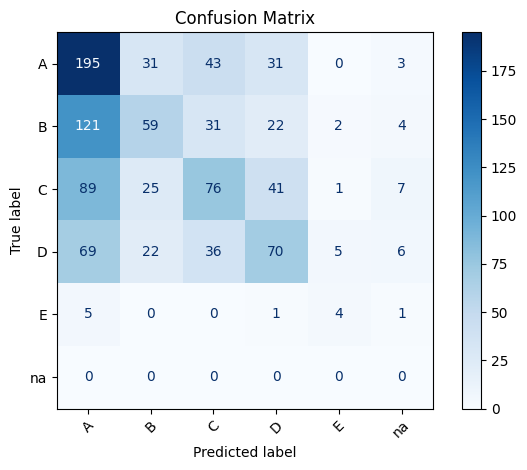

{'accuracy': 0.404,
 'precision': 0.3339888272509261,
 'recall': 0.31809878968263744}

In [50]:
evaluation_suite.evaluate_discrete_answers(predicted_answer_multiple_choice, ground_truth, experiment_name="FT_7bcoder_MC_1000")

## True False

In [70]:
tf_testset = testset['true_false']
tf_testset = tf_testset.shuffle(seed=42)

In [71]:
predictions_tf = []

for i in tqdm(range(1000)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(tf_testset[i]['prompt'],
                  max_new_tokens=20,
                  temperature=0.1,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True
                  )

  predictions_tf.append(response)

100%|██████████| 1000/1000 [15:15<00:00,  1.09it/s]


In [72]:
predicted_answer_true_false = []
for sample in predictions_tf:
  match = re.search(r'Please state only False or True:\s*\n*(True|False)\.*', sample[0].get('generated_text'), re.IGNORECASE)
  if match:
      answer = match.group(1)
      predicted_answer_true_false.append({"predicted_answer": answer})
  else:
      predicted_answer_true_false.append({"predicted_answer": "na"})

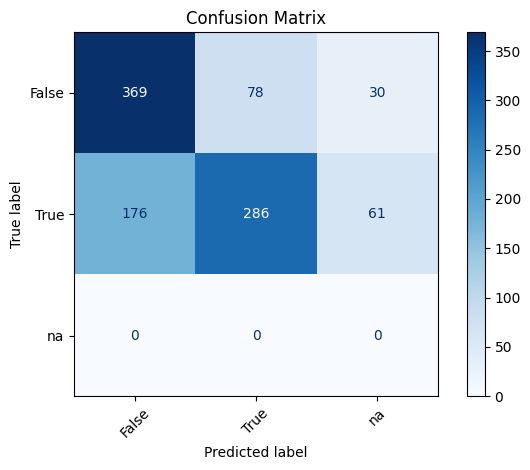

{'accuracy': 0.655,
 'precision': 0.4875928352992573,
 'recall': 0.44014334331445343}

In [74]:
# Extract predicted and correct answers
y_pred_true_false = [entry['predicted_answer'] for entry in predicted_answer_true_false]
y_true_true_false = [entry['answer'] for entry in tf_testset.to_list()[:1000]]

evaluation_suite.evaluate_discrete_answers(y_pred_true_false, y_true_true_false, experiment_name="FT_7bcoder_TF_1000")

## Short Answer

In [58]:
sa_testset = testset['short_answer']


In [60]:
predictions_sa = []

for i in tqdm(range(500)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(sa_testset[i]['prompt'],
                  max_new_tokens=100,
                  temperature=0.7,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True,)

  predictions_sa.append(response)

100%|██████████| 500/500 [37:55<00:00,  4.55s/it]


In [63]:
predicted_answer_short_answer = []
blocked_answers = 0
for sample in predictions_sa:
  match = re.search(
      r'### You are a medical expert and equipped to answer this specific question. Please answer:\s*(.+)',
      sample[0].get('generated_text'),
      re.DOTALL
  )
  if match:
      answer = match.group(1).strip()
      if answer.lower().startswith("i'm sorry, but"):
        answer = "N/A"
        blocked_answers += 1
      predicted_answer_short_answer.append({"predicted_answer": answer})
  else:
      predicted_answer_short_answer.append({"predicted_answer": "na"})

In [64]:
print(predicted_answer_short_answer)

[{'predicted_answer': '1992: 100 cases 1995: 130 cases 1996: 160 cases 1997: 100 cases 1998: 150 cases 1999: 180 cases 2000: 150 cases 2001: 250 cases 2002: 100 cases 2'}, {'predicted_answer': 'Anterior hip dislocations are common in women and older patients. These dislocations occur when the hip joint is displaced anteriorly, which means that the thigh bone (femur) is dislocated forward. Anterior hip dislocations are more common in women because they are more likely to have weakened ligaments and tendons in the hip joint, which can make them more prone to dislocation. Additionally, older patients are more likely to have osteoarthritis, which can weaken the hip joint and make it'}, {'predicted_answer': 'Polycythemia is a condition in which the number of red blood cells in the body is abnormally high. This can lead to anemia, which is a decrease in the number of red blood cells, or a condition called macrocytosis. Polycythemia is a rare condition that can occur in both children and adul

In [65]:
ground_truth_sa = [entry['answer'] for entry in sa_testset.to_list()[:500]]
predicted_answer_short_answer = [entry['predicted_answer'] for entry in predicted_answer_short_answer]

evaluation_suite.evaluate_string_answers(predicted_answer_short_answer, ground_truth_sa, experiment_name="FT_7bcoder_SA_500")

rouge_scores [{'rouge1': 0.025, 'rouge2': 0.0, 'rougeL': 0.025}, {'rouge1': 0.31155778894472363, 'rouge2': 0.14213197969543148, 'rougeL': 0.21105527638190952}, {'rouge1': 0.4925373134328358, 'rouge2': 0.25757575757575757, 'rougeL': 0.3731343283582089}, {'rouge1': 0.22602739726027396, 'rouge2': 0.02758620689655172, 'rougeL': 0.136986301369863}, {'rouge1': 0.37333333333333335, 'rouge2': 0.14349775784753363, 'rougeL': 0.24000000000000002}, {'rouge1': 0.27710843373493976, 'rouge2': 0.06097560975609755, 'rougeL': 0.1686746987951807}, {'rouge1': 0.08823529411764706, 'rouge2': 0.030303030303030307, 'rougeL': 0.08823529411764706}, {'rouge1': 0.1518987341772152, 'rouge2': 0.051948051948051945, 'rougeL': 0.1518987341772152}, {'rouge1': 0.37606837606837606, 'rouge2': 0.06956521739130435, 'rougeL': 0.22222222222222224}, {'rouge1': 0.5347593582887701, 'rouge2': 0.2594594594594595, 'rougeL': 0.36363636363636365}, {'rouge1': 0.5204081632653061, 'rouge2': 0.34020618556701027, 'rougeL': 0.4183673469387

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.025, 'rouge2': 0.0, 'rougeL': 0.025}, {'rouge1': 0.31155778894472363, 'rouge2': 0.14213197969543148, 'rougeL': 0.21105527638190952}, {'rouge1': 0.4925373134328358, 'rouge2': 0.25757575757575757, 'rougeL': 0.3731343283582089}, {'rouge1': 0.22602739726027396, 'rouge2': 0.02758620689655172, 'rougeL': 0.136986301369863}, {'rouge1': 0.37333333333333335, 'rouge2': 0.14349775784753363, 'rougeL': 0.24000000000000002}, {'rouge1': 0.27710843373493976, 'rouge2': 0.06097560975609755, 'rougeL': 0.1686746987951807}, {'rouge1': 0.08823529411764706, 'rouge2': 0.030303030303030307, 'rougeL': 0.08823529411764706}, {'rouge1': 0.1518987341772152, 'rouge2': 0.051948051948051945, 'rougeL': 0.1518987341772152}, {'rouge1': 0.37606837606837606, 'rouge2': 0.06956521739130435, 'rougeL': 0.22222222222222224}, {'rouge1': 0.5347593582887701, 'rouge2': 0.2594594594594595, 'rougeL': 0.36363636363636365}, {'rouge1': 0.5204081632653061, 'rouge2': 0.34020618556701027, 'rougeL': 0.41836734693

{'avg_bleu': 0.048498057042039876,
 'avg_meteor': 0.2066435180104819,
 'rouge1': 0.2627076874771316,
 'rouge2': 0.10921294121096219,
 'rougeL': 0.1875882810833192,
 'word_similarity': 0.8361659049987793,
 'sentence_similarity': 0.6651050635389983,
 'paragraph_similarity': 0.8361659049987793,
 'semantic_match_score': 0.7848476679254323,
 'precision': 0.8342841863632202,
 'recall': 0.8376531004905701,
 'f1': 0.8353339433670044,
 'avg_cosine_similarity': 0.8361659269481897,
 'avg_reasoning_coherence': 0.6539105674698948}

## Multi Hop

In [66]:
mh_testset = testset['multi_hop']

In [67]:
predictions_mh = []

for i in tqdm(range(500)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(mh_testset[i]['prompt'],
                  max_new_tokens=200,
                  temperature=0.7,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True
                  )

  predictions_mh.append(response)

100%|██████████| 500/500 [1:14:04<00:00,  8.89s/it]


In [68]:
predicted_answer_mh = []
blocked_answers = 0
for sample in predictions_mh:
  match = re.search(
      r'### You are a medical expert and equipped to answer this specific question. Please answer the question and elaborate what steps you took:\s*(.+)',
      sample[0].get('generated_text'),
      re.DOTALL
  )
  if match:
      answer = match.group(1).strip()
      if answer.lower().startswith("i'm sorry, but"):
        answer = "N/A"
        blocked_answers += 1
      predicted_answer_mh.append({"predicted_answer": answer})
  else:
      predicted_answer_mh.append({"predicted_answer": "na"})

In [69]:
ground_truth_mh = [entry['answer'] for entry in mh_testset.to_list()[:500]]
predicted_answer_mh = [entry['predicted_answer'] for entry in predicted_answer_mh]

evaluation_suite.evaluate_string_answers(predicted_answer_mh, ground_truth_mh, experiment_name="FT_7bcoder_MH_500")

rouge_scores [{'rouge1': 0.5324675324675324, 'rouge2': 0.26143790849673204, 'rougeL': 0.2922077922077922}, {'rouge1': 0.4566929133858268, 'rouge2': 0.1746031746031746, 'rougeL': 0.21259842519685038}, {'rouge1': 0.550185873605948, 'rouge2': 0.23970037453183518, 'rougeL': 0.34200743494423785}, {'rouge1': 0.43589743589743585, 'rouge2': 0.22413793103448273, 'rougeL': 0.3076923076923077}, {'rouge1': 0.42574257425742573, 'rouge2': 0.1, 'rougeL': 0.21782178217821782}, {'rouge1': 0.32160804020100503, 'rouge2': 0.1218274111675127, 'rougeL': 0.21105527638190952}, {'rouge1': 0.45936395759717313, 'rouge2': 0.11387900355871887, 'rougeL': 0.19787985865724383}, {'rouge1': 0.31578947368421056, 'rouge2': 0.07346938775510203, 'rougeL': 0.20242914979757087}, {'rouge1': 0.3853211009174312, 'rouge2': 0.12037037037037039, 'rougeL': 0.18348623853211007}, {'rouge1': 0.42975206611570244, 'rouge2': 0.11666666666666667, 'rougeL': 0.19008264462809918}, {'rouge1': 0.5367965367965368, 'rouge2': 0.2270742358078603, 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.5324675324675324, 'rouge2': 0.26143790849673204, 'rougeL': 0.2922077922077922}, {'rouge1': 0.4566929133858268, 'rouge2': 0.1746031746031746, 'rougeL': 0.21259842519685038}, {'rouge1': 0.550185873605948, 'rouge2': 0.23970037453183518, 'rougeL': 0.34200743494423785}, {'rouge1': 0.43589743589743585, 'rouge2': 0.22413793103448273, 'rougeL': 0.3076923076923077}, {'rouge1': 0.42574257425742573, 'rouge2': 0.1, 'rougeL': 0.21782178217821782}, {'rouge1': 0.32160804020100503, 'rouge2': 0.1218274111675127, 'rougeL': 0.21105527638190952}, {'rouge1': 0.45936395759717313, 'rouge2': 0.11387900355871887, 'rougeL': 0.19787985865724383}, {'rouge1': 0.31578947368421056, 'rouge2': 0.07346938775510203, 'rougeL': 0.20242914979757087}, {'rouge1': 0.3853211009174312, 'rouge2': 0.12037037037037039, 'rougeL': 0.18348623853211007}, {'rouge1': 0.42975206611570244, 'rouge2': 0.11666666666666667, 'rougeL': 0.19008264462809918}, {'rouge1': 0.5367965367965368, 'rouge2': 0.2270742358078603

{'avg_bleu': 0.07859556684627497,
 'avg_meteor': 0.303354508435421,
 'rouge1': 0.4055580283273296,
 'rouge2': 0.16223980359620588,
 'rougeL': 0.24735993401071657,
 'word_similarity': 0.9469273686408997,
 'sentence_similarity': 0.7899361252784729,
 'paragraph_similarity': 0.9469273686408997,
 'semantic_match_score': 0.8998299524001777,
 'precision': 0.8618834018707275,
 'recall': 0.8791455626487732,
 'f1': 0.8702476620674133,
 'avg_cosine_similarity': 0.9469273283816874,
 'avg_reasoning_coherence': 0.7485934608280659}